In [22]:
import numpy
import time
import ipyparallel as ipp
from scipy import stats
from qiskit.chemistry import FermionicOperator
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.operators.legacy import op_converter
#from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit.quantum_info import Pauli
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, CircuitStateFn 
import scipy
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.compiler import transpile
from qiskit.circuit.random import random_circuit
from qiskit.chemistry.components.variational_forms import UCCSD
from tqdm import tqdm
from qiskit.providers.aer import AerSimulator

In [23]:
import warnings
warnings. filterwarnings('ignore')

In [24]:
c = ipp.Client()
num_qubits=8

In [25]:
def qubitOp(h1,h2):
    qubit_op=FermionicOperator(h1,h2).mapping('parity')
    return qubit_op
def egBandHamiltonian(U):
    #Getting chemical Potential for Half-Filling
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                elems=line.split()
                eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
                eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1=eg_h1+chem_pot       
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            eg_h2[i,j,k,l] = eg_h2[i+num_sites,j+num_sites,k,l] = eg_h2[i,j,k+num_sites,l+num_sites]             = eg_h2[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
    qubitH=qubitOp(eg_h1,eg_h2)
    qubitH=Z2Symmetries.two_qubit_reduction(qubitH, 4)
    Hmat=op_converter.to_matrix_operator(qubitH).dense_matrix
    w,v=numpy.linalg.eigh(Hmat)
    Eg=w[0]
    state_g=v[:,0]
    return qubitH,Hmat,Eg,state_g

In [73]:
#One particle density matrix-statevector
def one_RDM_parity(data):
    import numpy
    from qiskit.chemistry import FermionicOperator
    from qiskit.aqua.operators import Z2Symmetries
    from qiskit.aqua.operators.legacy import op_converter
    state,num_qubits,i,j=data
    h1=numpy.zeros((num_qubits,num_qubits))*1j
    h2=numpy.zeros((num_qubits,num_qubits))*1j
    h1[i,j]=h1[j,i]=0.5
    h2[i,j]=0.5*1j
    h2[j,i]=-0.5*1j
    h1=FermionicOperator(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))).mapping('parity')
    h2=FermionicOperator(h2,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))).mapping('parity')
    h1=Z2Symmetries.two_qubit_reduction(h1, 4)
    h2=Z2Symmetries.two_qubit_reduction(h2, 4)
    print(h1.paulis,h2.paulis)
    h1=op_converter.to_matrix_operator(h1).dense_matrix
    h2=op_converter.to_matrix_operator(h2).dense_matrix
    h=h1+1j*h2
    return state@h@state
def M_parity(state):
    num_qubits=8
    arr=[(state,num_qubits,i,j) for i in range(num_qubits) for j in range(num_qubits) if i<=j]
    result = c[:].map_async(one_RDM_parity, arr)
    M_arr=result.get()
    adapt_RDM=numpy.zeros((num_qubits,num_qubits))*1j
    ind=0
    for i in range(num_qubits):
        for j in range(i,num_qubits):
            adapt_RDM[i,j]=M_arr[ind]
            adapt_RDM[j,i]=numpy.conjugate(M_arr[ind])
            ind=ind+1
    return adapt_RDM
def dist(rho1,rho2):
    rho_diff=rho1-rho2
    entries=num_qubits*num_qubits
    d_12=numpy.sum(numpy.abs(rho_diff))/len(rho_diff[numpy.abs(rho_diff)>1e-3])#numpy.sqrt(numpy.sum(numpy.diag(numpy.dot(rho_diff,numpy.conjugate(rho_diff.T)))))
    return d_12

In [154]:
def error_one_body_DM(adapt_RDMs,exact_RDM,U):
    error_arr=[]
    qubit_inds=[]
    for j in range(num_qubits-2):
        for k in range(j,num_qubits-2):
            if(numpy.abs(exact_RDM[j,k])>1e-6):
                qubit_inds.append((j,k))
    for i in range(len(adapt_RDMs)):
        err_arr=[]
        for l in range(len(qubit_inds)):
            j,k=qubit_inds[l]
            err_arr.append(numpy.abs(adapt_RDMs[i][j,k]-exact_RDM[j,k]))
        error_arr.append(numpy.array(err_arr))            
    error_arr=numpy.array(error_arr)
    qubit_inds_str=' '.join(["("+str(qubit_inds[i][0])+" "+str(qubit_inds[i][1])+")" for i in range(len(qubit_inds))])
    f=open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-AdaDelta_parity_enc/qasm_error_one_body_dm.txt','w')
    f.write(qubit_inds_str+'\n')
    f.close()
    for i in range(len(adapt_RDMs))[:-1]:
        with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-AdaDelta_parity_enc/qasm_error_one_body_dm.txt','a') as f:
            err_str=" ".join([str(error_arr[i][j]) for j in range(len(qubit_inds))])
            print(err_str,file=f)
    return True

In [75]:
U=7
qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)

In [76]:
def Energy(params):
    circ=var_form_base.construct_circuit(parameters=params_arr[i])
    state=execute(circ,backend,shots=1024).result().get_statevector() 
    E=(state.conj()@Hmat@state).real
    return E

In [77]:
exactRDM=M_parity(state_g)

In [131]:
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-AdaDelta_parity_enc/dataForQubitAdapt_eg_model_parity_qasm.txt','r') as f:
#with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-SMO-parity-SV/dataForQubitAdapt_eg_model_parity_SV.txt','r') as f:
    lines=f.readlines()
    ExcOps=[]
    params_arr=[]
    for i in range(len(lines)):
        if lines[i][0]=='l':
            elems=lines[i].split('-')
            ExcOps.append(elems[1][1:-1])
            params_arr.append(eval(lines[i+2]))

In [139]:
circ=QuantumCircuit(6)
circ.x(0)
circ.x(3)
var_form_base=UCCSD(8,num_particles=4, initial_state=circ,qubit_mapping='parity',two_qubit_reduction=True)
var_form_base.manage_hopping_operators()
backend=Aer.get_backend('statevector_simulator')
adaptRDM_arr=[]
for i in range(len(ExcOps)):
    var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli(ExcOps[i])]]))
    print("Energy",Energy(params_arr[i]))
    circ=var_form_base.construct_circuit(parameters=params_arr[i])
    state=execute(circ,backend,shots=1024).result().get_statevector()
    elem=state[numpy.abs(state)>1e-3][0]
    print(elem)
    global_phase=numpy.sqrt(elem/elem.conj())
    state_phase_rmv=-global_phase.conj()*state
    adaptRDM_arr.append(M_parity(state_phase_rmv))
    print("overlap",numpy.abs(state_g.conj()@state))
    print("dist",dist(adaptRDM_arr[-1],exactRDM))

Energy -18.67289951027692
(0.224295184950462+0.4171173155821993j)
overlap 0.5532936042342754
dist 0.20204032786716808
Energy -18.691075406827203
(0.21010975765419215+0.4378693127412084j)
overlap 0.5687047116082729
dist 0.1949754073080195
Energy -18.95962847178692
(0.4839347287560363+0.01523090178595198j)
overlap 0.75094742875633
dist 0.14970788431613352
Energy -18.97919484957831
(0.4952600212656362+9.145818132198168e-05j)
overlap 0.7722750878438732
dist 0.14260713635491998
Energy -19.00406449500491
(0.41547426828342415+0.058485571671322754j)
overlap 0.7687178964410738
dist 0.1394844920403116
Energy -19.005744067095332
(-0.007873877474087979-0.0009899733307820824j)
overlap 0.7714188474665238
dist 0.13825511770585666
Energy -19.007350815230133
(0.0011090439410899847+0.00016122989832789928j)
overlap 0.773826673436233
dist 0.1374575414336262
Energy -19.007420409401874
(0.007838852456106047+0.0011620891672081233j)
overlap 0.7736412263232513
dist 0.13759647383490145
Energy -19.00743583780134

In [144]:
numCXarr=[]
for i in range(len(ExcOps)):
    numCXarr.append(2*(len(numpy.where(numpy.array(list(ExcOps[i]))!='I')[0])-1))
numCXarr=numpy.cumsum(numCXarr)

In [159]:
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-AdaDelta_parity_enc/qasm_error_one_body_dm.txt','r') as f:
    lines=f.readlines()
    ind=0
    dm_error_arr_qasm=numpy.zeros((len(lines[1:]),20))
    for line in lines[1:]:
        elems=line.split()
        for i in range(len(elems)):
            dm_error_arr_qasm[ind][i]=float(elems[i])
        ind=ind+1 

In [167]:
#(0 0) (0 2) (1 1) (1 3) (2 2) (3 3) (4 4) (4 6) (5 5) (5 7) (6 6) (7 7)

In [161]:
import matplotlib.pyplot as plt

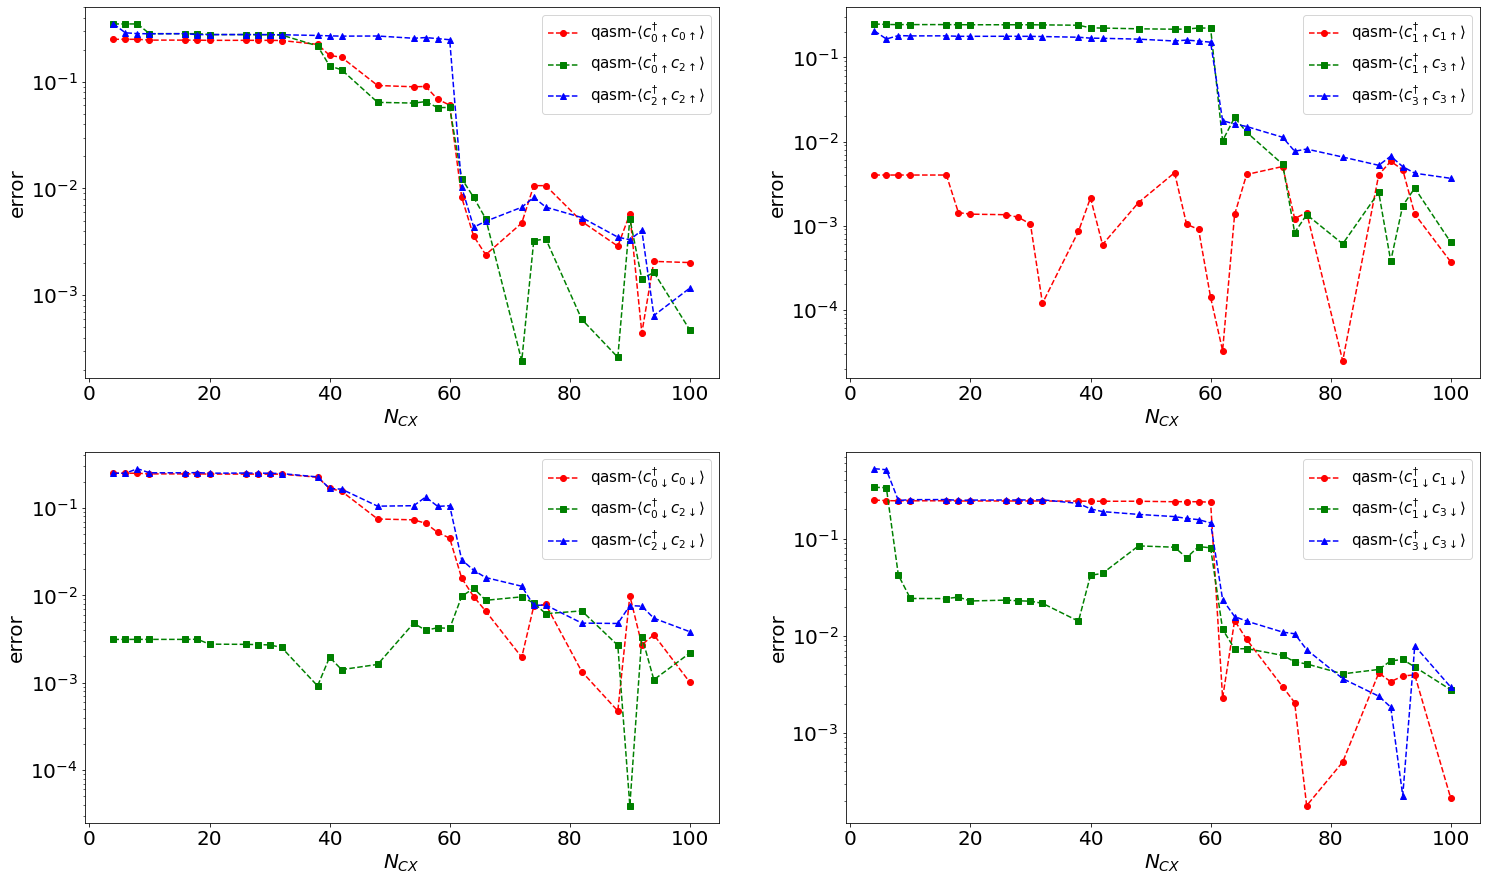

In [170]:
figure,ax=plt.subplots(2,2,figsize = (25,15))
error_arr=dm_error_arr_qasm
ax[0][0].set_xlabel(r"$N_{CX}$",fontsize=20)
ax[0][0].set_ylabel("error",fontsize=20)
ax[0][0].set_yscale('log')
ax[0][1].set_xlabel(r"$N_{CX}$",fontsize=20)
ax[0][1].set_ylabel("error",fontsize=20)
ax[0][1].set_yscale('log')
ax[1][0].set_xlabel(r"$N_{CX}$",fontsize=20)
ax[1][0].set_ylabel("error",fontsize=20)
ax[1][0].set_yscale('log')
ax[1][1].set_xlabel(r"$N_{CX}$",fontsize=20)
ax[1][1].set_ylabel("error",fontsize=20)
ax[1][1].set_yscale('log')
ax[0][0].tick_params(labelsize=20)
ax[0][1].tick_params(labelsize=20)
ax[1][0].tick_params(labelsize=20)
ax[1][1].tick_params(labelsize=20)
ax[0][0].plot(numCXarr[1:],error_arr[:,0],label=r'qasm-$\langle c^{\dagger}_{0\uparrow}c_{0\uparrow}\rangle$',color='red',marker='o',linestyle='--')
ax[0][0].plot(numCXarr[1:],error_arr[:,1],label=r'qasm-$\langle c^{\dagger}_{0\uparrow}c_{2\uparrow}\rangle$',color='green',marker='s',linestyle='--')
ax[0][0].plot(numCXarr[1:],error_arr[:,4],label=r'qasm-$\langle c^{\dagger}_{2\uparrow}c_{2\uparrow}\rangle$',color='blue',marker='^',linestyle='--')
ax[0][1].plot(numCXarr[1:],error_arr[:,2],label=r'qasm-$\langle c^{\dagger}_{1\uparrow}c_{1\uparrow}\rangle$',color='red',marker='o',linestyle='--')
ax[0][1].plot(numCXarr[1:],error_arr[:,3],label=r'qasm-$\langle c^{\dagger}_{1\uparrow}c_{3\uparrow}\rangle$',color='green',marker='s',linestyle='--')
ax[0][1].plot(numCXarr[1:],error_arr[:,5],label=r'qasm-$\langle c^{\dagger}_{3\uparrow}c_{3\uparrow}\rangle$',color='blue',marker='^',linestyle='--')
ax[1][0].plot(numCXarr[1:],error_arr[:,6],label=r'qasm-$\langle c^{\dagger}_{0\downarrow}c_{0\downarrow}\rangle$',color='red',marker='o',linestyle='--')
ax[1][0].plot(numCXarr[1:],error_arr[:,7],label=r'qasm-$\langle c^{\dagger}_{0\downarrow}c_{2\downarrow}\rangle$',color='green',marker='s',linestyle='--')
ax[1][0].plot(numCXarr[1:],error_arr[:,10],label=r'qasm-$\langle c^{\dagger}_{2\downarrow}c_{2\downarrow}\rangle$',color='blue',marker='^',linestyle='--')
ax[1][1].plot(numCXarr[1:],error_arr[:,8],label=r'qasm-$\langle c^{\dagger}_{1\downarrow}c_{1\downarrow}\rangle$',color='red',marker='o',linestyle='--')
ax[1][1].plot(numCXarr[1:],error_arr[:,9],label=r'qasm-$\langle c^{\dagger}_{1\downarrow}c_{3\downarrow}\rangle$',color='green',marker='s',linestyle='--')
ax[1][1].plot(numCXarr[1:],error_arr[:,11],label=r'qasm-$\langle c^{\dagger}_{3\downarrow}c_{3\downarrow}\rangle$',color='blue',marker='^',linestyle='--')
ax[0][0].legend(fontsize=15)
ax[0][1].legend(fontsize=15)
ax[1][0].legend(fontsize=15)
ax[1][1].legend(fontsize=15)
plt.savefig('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-AdaDelta_parity_enc/qasm_errorU=7dm.png')

In [72]:
error_one_body_DM(adaptRDM_arr,exactRDM,U)

True